pretext tasks:
- shuffle the order of slices in sandwich, figure out correct slice order?

- jigsaw?

# Center Crop fastmri tfm??

## Setup gdrive

In [1]:
PROJ       = "fastmri"

In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

In [4]:
%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc

pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


In [5]:
%run "$PROJ_PATH/04_kspace_tfms.ipynb" # get the tfms to test

## Setup

In [ ]:
PROJ       = "fastmri"

# clone repo
!git clone https://github.com/RGologorsky/fastmri.git

# pip install/import
%run "$PROJ/common_constants_env.ipynb" # pip install fastai, fastmri, etc
%run "$PROJ/common_archs.ipynb"         # get simple cnn (stride 2 all the way)
%run "$PROJ/04_kspace_tfms.ipynb"       # get the kspace tfms

fatal: destination path 'fastmri' already exists and is not an empty directory.
pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


In [ ]:
%run "$PROJ/04_kspace_tfms.ipynb"       # get the kspace tfms

# Raw Items 

Fnames

1. Highres: MR image from **fully sampled ksapce**
2. Lowres: MR image from **undersampled kspace**

Get raw items. Raw items: list of (fname, attribute dict), derived from fn2attr.json stored in Gdrive. The attribute dict contains relevant info such as number of slices in the given h5 file.

In [6]:
from google.colab import drive
from pathlib      import Path
import json

# choose dataset
ds_name = "knee_singlecoil_val"
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

# Mount Google Drive 
ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

# Path to Proj
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ

# Load json containing attr info
path_json = PROJ_PATH/"data"/DS2DIR[ds_name]/"fn2attr.json"
fn2attr = json.load(path_json)
fn2attr_items = L(i for i in fn2attr.items())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # Sandwich Tfm

Given index, return sandwich at that index.

Setup/init: 
- pass a list of (fname, attribute_dict), each fname contains a kspace volume.
- pass $n_{seq}$, the desired sequence length. For example  n_seq=5 yields a kslice sequence of length 5, ($x$-2, $x$-1, $x$, $x$+1, $x$+2).

Encode: given index, 
- look up the correct file to open, 
- find the right slice sequence ($x$-2, $x$-1, $x$, $x$+1, $x$+2),
- return slice sequence and target slice $x$.

In [7]:
# converts complex k-space (2channel) to magnitude-only k-space (1channel)
class K2ImTfm(Transform):
  def encodes(self, t:TensorCategory): return t
  def encodes(self, t:Tensor): return C.apply(t, CenteredTfms.k2im(), post=C.complex2mgn)

In [40]:
from itertools import permutations 

# indexes into array of kspace slices
class ToSandwClassifier(Transform):

  # returns index in fn2attr corresponding to given sandwich
  def sandw2fn_idx(self, i): return np.searchsorted(self.cumsum_n_sandws, i)
  
  # permutations, array/string form
  @staticmethod
  def perm2str(p): return ','.join(map(str, p))
  @staticmethod
  def str2perm(s): return np.array([int(x) for x in s.split(',')])

  # inverse permutation (from shuffled x seq to correct x seq)
  @staticmethod
  def get_perm_inv(p): 
    d = dict(zip(p, range(len(p))))
    return np.array([d[i] for i in range(len(p))])


  # set permutation orders for epoch (to avoid calling random repeatedly)
  def set_epoch_perms(self):
    self.perm_list = np.random.randint(self.c, size=self.total_n_sandws)

  def __init__(self, fn2attr_items, n_seq = 5):

    # permutations
    self.n_seq = n_seq
    self.c = math.factorial(n_seq)
    self.vocab = CategoryMap([ToSandwClassifier.perm2str(p) for p in permutations(range(n_seq))])

    # fnames, volumes, slices, sandws, etc
    self.fn2attr_items = fn2attr_items
   
    # how many slices/sandwiches per file
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.n_sandws = [n-(self.n_seq-1) for n in self.n_slices]

    # given dataset index, cumsum is used to index into appropriate file
    self.cumsum_n_slices = np.cumsum(self.n_slices)
    self.cumsum_n_sandws = np.cumsum(self.n_sandws)

    # total number of slices/sandwiches in dataset (for reference)
    self.total_n_slices   = self.cumsum_n_slices[-1]
    self.total_n_sandws   = self.cumsum_n_sandws[-1]

    # set perms for the epoch
    self.set_epoch_perms()

  def encodes(self, sandw_idx):
    # sandw number (idx 0 = first sandwich = sandwich #1)
    n_sandw = sandw_idx + 1
    
    # get file
    fn_idx  = self.sandw2fn_idx(n_sandw)
    fname   = self.fn2attr_items[fn_idx][0]

    # sandwich index within file
    n_sandw_prior_vol = 0 if fn_idx == 0 else self.cumsum_n_sandws[fn_idx - 1]
    sw_idx  = sandw_idx - n_sandw_prior_vol # 15sandw in file = 14th index
    
    # get kspace sandwich, target slice + neighbor slices on either side
    with h5py.File(fname, 'r') as data:
      ksandw = data['kspace'][sw_idx:sw_idx+self.n_seq]      
    
    # shuffle
    perm_number = self.perm_list[sandw_idx] # perm_number [0,n_seq!]
    perm = ToSandwClassifier.str2perm(self.vocab[perm_number])
    return T.to_tensor(ksandw[perm]), TensorCategory(perm_number)

  def decodes(self, o):
    perm_ksandw, perm_category = o
    perm = self.vocab[perm_category]
    return perm_ksandw, perm

In [9]:
np.random.randint(5,size=10)

array([0, 0, 3, 3, 1, 3, 2, 2, 4, 0])

In [10]:
print(*fn2attr_items[:5], sep="\n")

('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000314.h5', {'n_slices': 32, 'kspace_shape': [32, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000031.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000480.h5', {'n_slices': 33, 'kspace_shape': [33, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000071.h5', {'n_slices': 35, 'kspace_shape': [35, 640, 372], 'padding_left': 19, 'padding_right': 354})


In [11]:
shapes = [tuple(o[1]["kspace_shape"][1:]) for o in fn2attr_items]
list(set(shapes))

[(640, 454), (640, 400), (640, 644), (640, 372)]

# Datasets

Each raw item is a sequence of neighboring (fully-sampled) kslice magnitude-only images, $X_i = \{x_{i-2}, x_{i-1}, x_i, x_{i+1}, x_{i+2} \}$.

After tfm,
1. input: permuted sequence of images (e.g. abcd $\to$ dabc)
2. target: the correct ordering of images (**3012**) 
  - 0 idx in input should be moved to idx **3**
  - 1 idx in input should be moved to idx **0**
  - 2 idx in input should be moved to idx **1**
  - 3 idx in input should be moved to idx **2**

In [12]:
perm = np.array([3,0,1,2])
iperm = ToSandwClassifier.get_perm_inv(perm)

orig = np.array(["a","b","c","d"])
input = np.array(["d","a","b","c"])

np.testing.assert_array_equal(orig[perm], input)
np.testing.assert_array_equal(input[iperm], orig)

In [25]:
# setup the transform
sandw_tfm = ToSandwClassifier(fn2attr_items, n_seq=5)
print(f"total #sandwiches = {sandw_tfm.total_n_sandws}")

# dataset = indices, sandw_tfm converts index to sandwich
raw_items = range(sandw_tfm.total_n_sandws)

# split between training/valid
splitter = RandomSplitter(valid_pct=0.2, seed=42)
splits   = splitter(raw_items)
print(f"#train/#valid = {len(splits[0]), len(splits[1])}")

# complex k space sandw
k_ds = TfmdLists(raw_items, tfms=[sandw_tfm], splits=splits)


total #sandwiches = 1196
#train/#valid = (957, 239)


In [ ]:

# magnitude im space sandw
im_ds = TfmdLists(k_ds, tfms=[K2ImTfm], splits=splits)

# Viz datasets

In [20]:
def toL(t): return [t[i] for i in range(t.shape[0])]

In [21]:
import numpy

In [35]:
i = np.random.randint(len(k_ds))
ksandw, perm_str = sandw_tfm.decodes(k_ds[i])
imsandw = C.apply(ksandw, CenteredTfms.k2im(), post=C.complex2mgn)

In [23]:
i = np.random.randint(len(im_ds))
imsandw, perm_str     = im_ds[i]


NameError: ignored

In [36]:
perm_str.split(',')

['4', '2', '0', '1', '3']

In [ ]:
np.array([int(x) for x in s.split(',')])

In [39]:
perm_arr = sandw_tfm.str2perm(perm_str)
perm_arr

array([4, 2, 0, 1, 3])

In [42]:
ToSandwClassifier.get_perm_inv(perm_arr)

array([2, 3, 1, 4, 0])

Sandwich 123, perm 4,2,0,1,3
[4 2 0 1 3]
[2 3 1 4 0]
torch.Size([5, 640, 372])


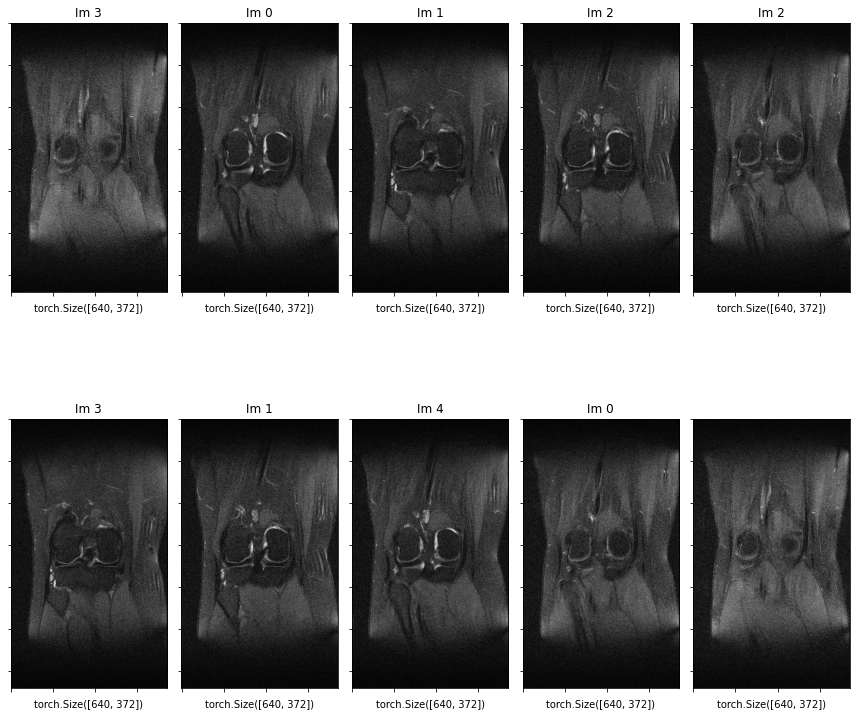

In [49]:

print(f"Sandwich {i}, perm {perm_str}")

perm_arr = sandw_tfm.str2perm(perm_str)
perm_inv = ToSandwClassifier.get_perm_inv(perm_arr)

print(perm_arr)
print(perm_inv)

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

# MRs in (magnitude) image space
print(imsandw.shape)
ims  = toL(imsandw) + toL(imsandw[perm_inv])
titles  = [f"Im {i}" for i in perm] + [f"Im {i}" for i in perm_inv]

plot(ims, titles, nrows=2, ncols=sandw_tfm.n_seq, figsize=(12,12))

# Dataloaders

Define parameters

In [ ]:
bs = 8
num_workers = 1

Define dataloaders (learning in image space)

# Data Augs

TODO

In [ ]:
Resize??

In [ ]:
sz = (640,372)
rsz = Resize(sz, method="crop", pad_mode="center")

In [ ]:
sz = (640,372)

item_tfms  = [T.center_crop(sz)]
batch_tfms = [] # partial(C.apply, tfms=C.complex2magn) [IntToFloatTensor] #, k2imTfm, Complex2Channel] # Normalize? SaveShape

crop_lr_dls = crop_lr_ds.dataloaders(
          after_item  = item_tfms, 
          after_batch = batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

In [ ]:
#crop_lr_dls.train_ds
#crop_lr_dls.train_ds.tfms

In [ ]:
# x,y = crop_lr_dls.one_batch()

In [ ]:
# print(*[(i,lr_dls.train_ds[i][0].shape) for i in range(10)], sep="\n")
# lr_dls.train_ds
# lr_dls.train_ds.tfms -- list of tfms

xb torch.Size([3, 5, 640, 372]), yb torch.Size([3, 640, 372])


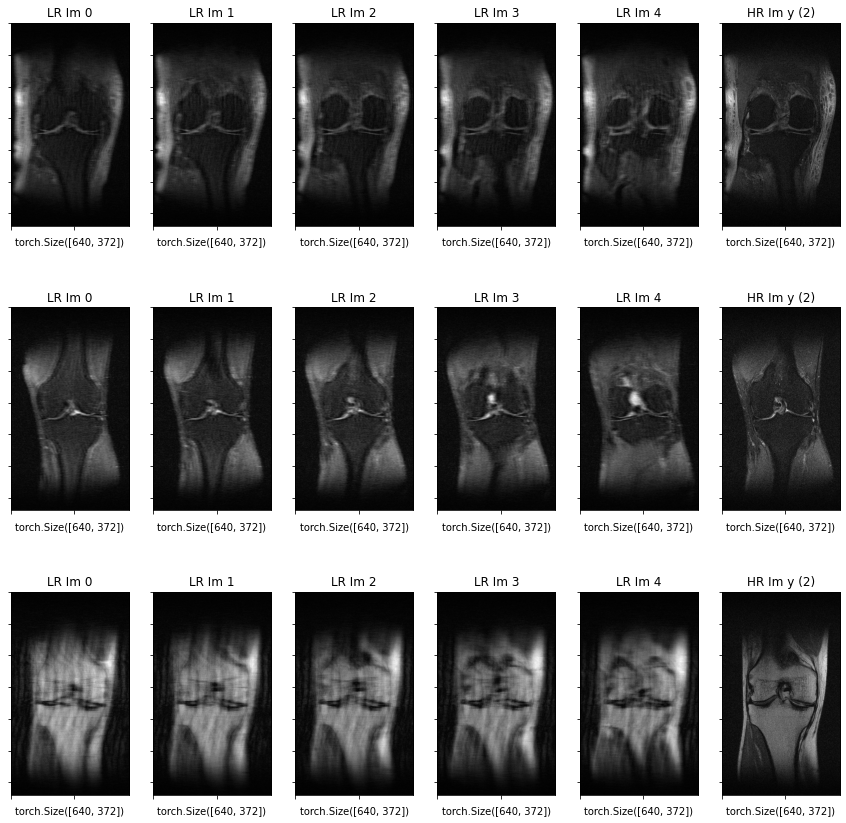

In [ ]:
# get batch
show_bs = 3

xb, yb = crop_lr_dls.one_batch()
xb, yb = to_cpu(xb)[:show_bs], to_cpu(yb)[:show_bs]
print(f"xb {xb.shape}, yb {yb.shape}")

# magnitude im space
rev_xb = xb #C.apply(xb, C.complex2mgn)
rev_yb = yb #C.apply(yb, C.complex2mgn)

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

# MRs in (magnitude) image space - each row = (x slice sequence, HR y)
imspace  = [j for i in range(len(rev_yb)) for j in (*toL(rev_xb[i]), rev_yb[i])]

im_titles = L([f"LR Im {i}" for i in range(n_seq)] + [f"HR Im y ({n_seq//2})"]) * show_bs

ims =  imspace
titles = im_titles

plot(ims, titles, nrows=show_bs, ncols=n_seq+1, figsize=(12,12))

# Architecture

tofp16

In [ ]:
math.factorial(5)

120

In [ ]:
# base model: resnet
base_resnet = xresnet34

c_in = sandw_tfm.n_seq
n_out = math.factorial(c_in) # the number of permutations is c_in!
print(f"c_in = {c_in}, n_out = {n_out}")

complex_im_resnet   = base_resnet(c_in=c_in, n_out=n_out, pretrained=False)

c_in = 5, n_out = 120


In [ ]:
sys.path.append('/content/fastMRI/banding_removal/fastmri/common')

In [ ]:
!pip install runstats

     |████████████████████████████████| 112kB 4.3MB/s 
  Created wheel for runstats: filename=runstats-1.8.0-cp36-cp36m-linux_x86_64.whl size=200025 sha256=f8148dbf78fe42f5d2293816ad3eebcba71c4ee899dc75290e9e0405313670af
  Stored in directory: /root/.cache/pip/wheels/58/f0/2b/509c185283b7a501bcad14d5ab99fd614c80dcb1f894897d0e
Successfully built runstats


In [ ]:
import evaluate as E

In [ ]:
metrics = [E.nmse, E.psnr, E.ssim]

In [ ]:
learn = unet_learner(crop_lr_dls, complex_im_resnet, metrics=metrics, pretrained=False)

TypeError: ignored

In [ ]:
unet_learner??

In [ ]:
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on=None, blur:bool=False,
                 self_attention:bool=False, y_range=None, last_cross:bool=True,
                 bottle:bool=False, cut=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    
    # I have defined size intentionally like this, so that it won't be a problem when 
    # the input is an image 
    size = next(iter(data.train_dl))[0].shape[-2:]
    n_input_channels = next(iter(data.train_dl))[0][0].size(0)    
        
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    
    # changing the first layer to suit our input
    if not n_input_channels == 3: 
        prev_layer = body[0]
        body[0] = nn.Conv2d(n_input_channels, prev_layer.out_channels, 
                      kernel_size=prev_layer.kernel_size, 
                      stride=prev_layer.stride, 
                      padding=prev_layer.padding, 
                      bias=prev_layer.bias)

    model = to_device(models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained and n_input_channels == 3: 
        learn.freeze()
        apply_init(model[2], nn.init.kaiming_normal_)
    else: apply_init(model, nn.init.kaiming_normal_)
    return learn